Launching 1000 Monte Carlo simulations over 252 days...

=== MONTE CARLO STRESS TEST RESULTS (1 Year) ===
Average Final Wealth (Market)    : 117.69
Average Final Wealth (Strategy)  : 119.27
--------------------------------------------------
WORST CASE SCENARIO (VaR 95% - Final Wealth):
 -> Market (Buy & Hold) : 80.23 (Risk of ending the year with < 80)
 -> HMM Strategy        : 90.12 (Risk of ending the year with < 90)


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


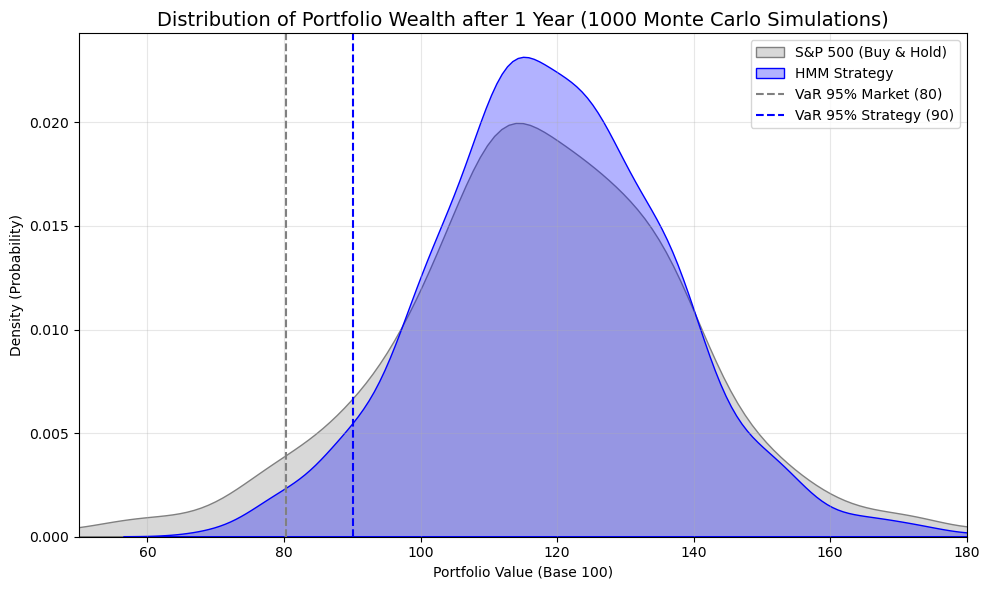

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ==========================================
# 1. MODEL PARAMETERS (From C++ Output)
# ==========================================
# Emission Parameters (Mu, Sigma, Nu)
# State 0 (Bull), State 1 (Bear), State 2 (Crash)
mus = np.array([0.000872, 0.000284, -0.001715])
sigmas = np.array([0.004797, 0.009378, 0.021426])
nu = 4.0

# Transition Matrix (A)
# P[i][j] = Probability of moving from i to j
A = np.array([
    [0.9911, 0.0086, 0.0004], # From Bull
    [0.0113, 0.9854, 0.0033], # From Bear
    [0.0000, 0.0230, 0.9770]  # From Crash
])

# --- BUG FIX: Normalization ---
# Ensures each row sums exactly to 1.0 to avoid numpy errors
A = A / A.sum(axis=1, keepdims=True)

# Simulation Parameters
n_simulations = 1000   # Number of fictitious years
n_days = 252           # Duration of one simulation (1 year)
risk_free_daily = 0.02 / 252 # Risk-free rate (2% annual)

print(f"Launching {n_simulations} Monte Carlo simulations over {n_days} days...")

# ==========================================
# 2. SIMULATION ENGINE
# ==========================================
final_wealth_market = []
final_wealth_strategy = []

np.random.seed(42) # For reproducibility

for sim in range(n_simulations):
    # Initialization
    current_state = 0 # Start in Bull state
    wealth_mkt = 100.0
    wealth_strat = 100.0
    
    # Time Loop (Days)
    for t in range(n_days):
        # 1. Generate next regime (Transition)
        next_state = np.random.choice([0, 1, 2], p=A[current_state])
        
        # 2. Generate Market Return (Student-t Emission)
        # np.random.standard_t(nu) generates a standardized Student-t value
        random_shock = np.random.standard_t(nu)
        market_return_log = mus[next_state] + sigmas[next_state] * random_shock
        market_return_simple = np.exp(market_return_log) - 1
        
        # 3. Apply Strategy (Allocation)
        # Decision is based on the current state estimate
        # If Crash (State 2) -> Cash, Else -> Market
        
        if current_state == 2: # In Crash Regime
            strat_return = risk_free_daily
        else:
            strat_return = market_return_simple
            
        # Update Wealth
        wealth_mkt *= (1 + market_return_simple)
        wealth_strat *= (1 + strat_return)
        
        # Update State
        current_state = next_state
        
    final_wealth_market.append(wealth_mkt)
    final_wealth_strategy.append(wealth_strat)

# ==========================================
# 3. RESULTS ANALYSIS
# ==========================================
results_mkt = np.array(final_wealth_market)
results_strat = np.array(final_wealth_strategy)

# Calculate extreme risk metrics (VaR 95% on final wealth)
# This is the threshold below which we fall only in the worst 5% of cases
var_95_mkt = np.percentile(results_mkt, 5)
var_95_strat = np.percentile(results_strat, 5)

print("\n=== MONTE CARLO STRESS TEST RESULTS (1 Year) ===")
print(f"Average Final Wealth (Market)    : {results_mkt.mean():.2f}")
print(f"Average Final Wealth (Strategy)  : {results_strat.mean():.2f}")
print("-" * 50)
print(f"WORST CASE SCENARIO (VaR 95% - Final Wealth):")
print(f" -> Market (Buy & Hold) : {var_95_mkt:.2f} (Risk of ending the year with < {var_95_mkt:.0f})")
print(f" -> HMM Strategy        : {var_95_strat:.2f} (Risk of ending the year with < {var_95_strat:.0f})")

# ==========================================
# 4. VISUALIZATION (Distribution)
# ==========================================
plt.figure(figsize=(10, 6))
sns.kdeplot(results_mkt, fill=True, label='S&P 500 (Buy & Hold)', color='grey', alpha=0.3)
sns.kdeplot(results_strat, fill=True, label='HMM Strategy', color='blue', alpha=0.3)

# Vertical lines for VaR
plt.axvline(var_95_mkt, color='grey', linestyle='--', label=f'VaR 95% Market ({var_95_mkt:.0f})')
plt.axvline(var_95_strat, color='blue', linestyle='--', label=f'VaR 95% Strategy ({var_95_strat:.0f})')

plt.title('Distribution of Portfolio Wealth after 1 Year (1000 Monte Carlo Simulations)', fontsize=14)
plt.xlabel('Portfolio Value (Base 100)')
plt.ylabel('Density (Probability)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xlim(50, 180) # Zoom on relevant area

plt.tight_layout()
plt.savefig("monte_carlo_distribution.png")
plt.show()